In [1]:
import requests
import pandas as pd
import nltk
from nltk import word_tokenize, download
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
download('punkt')
download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
import string
import re
from wordcloud import WordCloud
import seaborn as sns
from seaborn import heatmap
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.max_rows',5)

[nltk_data] Downloading package punkt to /Users/punkboy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/punkboy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/punkboy/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/punkboy/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
url = 'https://fraser.stlouisfed.org/api/title/1164/items?limit=200'
api_key = '84684284f3f69d577790cf821c718e4f'
title_id = "1164"
start_date = "2018-02-05"
end_date = "2023-12-31"

headers = {
    'X-API-Key': api_key
}

# Make the request to the FRASER API
response = requests.get(url, headers=headers)

# Check if the request was successful
if response.status_code == 200:
    # Get the response data
    data = response.json()
    print(data)
    if 'items' in data and len(data['items']) > 0:
        print("First item structure:", data['items'][0].keys())
    # Extract and print the speech names 
    for item in data.get('items', []):
        print(item.get('title'))
else:
    print('Error:', response.status_code, response.text)

{'format': 'json', 'page': 1, 'limit': 200, 'fields': ['*'], 'total': 115, 'records': [{'genre': ['speech'], 'language': ['eng'], 'location': {'url': ['https://fraser.stlouisfed.org/title/statements-speeches-jerome-h-powell-1164/discussion-crunch-time-fiscal-crises-role-monetary-policy-2378'], 'iiif_manifest_url': ['https://iiif.slf.digirati.io/presentation/2378'], 'apiUrl': ['https://fraser.stlouisfed.org/api//2378'], 'pdfUrl': ['https://fraser.stlouisfed.org/docs/historical/federal reserve history/bog_members_statements/powell_20130222.pdf'], 'textUrl': ['https://fraser.stlouisfed.org/files/text/historical/federal reserve history/bog_members_statements/powell_20130222.txt']}, 'titleInfo': [{'title': 'Discussion of "Crunch Time: Fiscal Crises and the Role of Monetary Policy"', 'subTitle': 'Remarks at the "U.S. Monetary Policy Forum," a Conference Sponsored by the University of Chicago Booth School of Business, New York, New York', 'titlePartNumber': ''}], 'originInfo': {'issuance': 'm

In [3]:
scraped_data = []
for record in data['records']:
    date_issued = record['originInfo']['dateIssued']
    text_url = record['location']['textUrl'][0]  
    response = requests.get(text_url)
    html_content = response.text  
    print(f"Date Issued: {date_issued}")
    print(f"Text URL: {text_url}")
    print("---")
    scraped_data.append({'date': date_issued, 'html': html_content})
df = pd.DataFrame(scraped_data)
df['date'] = pd.to_datetime(df['date'])
df = df[df['date'] >= '2018-02-13']
df.head()

Date Issued: February 22, 2013
Text URL: https://fraser.stlouisfed.org/files/text/historical/federal reserve history/bog_members_statements/powell_20130222.txt
---
Date Issued: March 4, 2013
Text URL: https://fraser.stlouisfed.org/files/text/historical/federal reserve history/bog_members_statements/powell_20130304.txt
---
Date Issued: March 7, 2013
Text URL: https://fraser.stlouisfed.org/files/text/historical/federal reserve history/bog_members_statements/powell_20130307.txt
---
Date Issued: June 27, 2013
Text URL: https://fraser.stlouisfed.org/files/text/historical/federal reserve history/bog_members_statements/powell_20130627.txt
---
Date Issued: July 2, 2013
Text URL: https://fraser.stlouisfed.org/files/text/historical/federal reserve history/bog_members_statements/powell_20130702.txt
---
Date Issued: October 3, 2013
Text URL: https://fraser.stlouisfed.org/files/text/historical/federal reserve history/bog_members_statements/powell_20131003.txt
---
Date Issued: October 11, 2013
Text 

,date,html
55,2018-02-13,"For release on delivery\n10:00 a.m. EST\nFebruary 13, 2018\n\nRemarks by\nJerome H. Powell\nChai..."
56,2018-02-27,"For release on delivery 8:30 a.m. EST February 27, 2018 Statement by Jerome H. Powell Chairman ..."
57,2018-04-06,"For release on delivery 1:30 p.m. EDT (12:30 p.m. CDT) April 6, 2018 The Outlook for the U.S. E..."
58,2018-05-08,"For release on delivery\n3:15 a.m. EDT (9:15 a.m. local time)\nMay 8, 2018\n\nMonetary Policy In..."
59,2018-05-25,"For release on delivery\n9:20 a.m. EDT (3:20 p.m. local time)\nMay 25, 2018\n\nFinancial Stabili..."


In [4]:
#Cleaning
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)
lemmer = WordNetLemmatizer()
def valid_word(word):
    return (word not in stop_words) and (word not in punctuation) 
def preProcess(txt):
    txt = txt.replace('\n', ' ')
    txt = txt.replace('\x0c', '')
    txt = txt.lower()
    date_pattern = re.compile(
    r'(?:january|february|march|april|may|june|july|august|september|october|november|december)'
    r'\s+\d{1,2},\s+\d{4}'
    )
    timezone_pattern = r'\b\d{1,2}:\d{2}\s*(a\.m\.|p\.m\.)\s*[a-z]{2,4}\b'
    intro_pattern = r'^.*?\bat\b'
    txt = re.sub(date_pattern, '', txt, count=2)
    txt = re.sub(timezone_pattern, '', txt)
    txt = re.sub(intro_pattern, '', txt, count =1)
    tokens = word_tokenize(txt)
    fintxt = []
    for word in tokens:
        if valid_word(word):
            lem = lemmer.lemmatize(word)
            fintxt.append(word)
        final = ' '.join(fintxt)
    return final
df['processed']= df['html'].apply(preProcess)


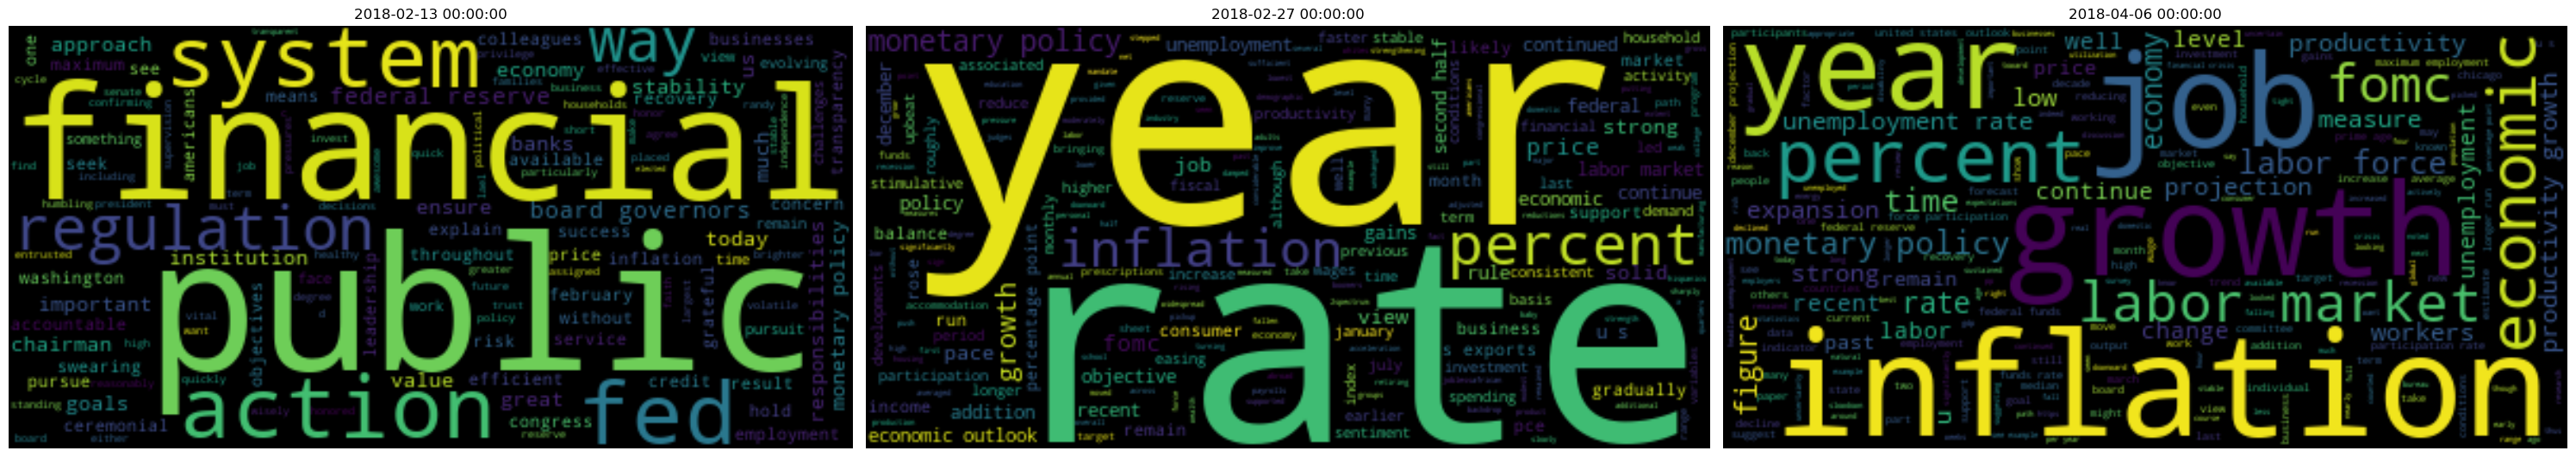

In [5]:
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(30, 20))

for (index, row), ax in zip(df.iterrows(), axs.ravel()):
    wc = WordCloud().generate(row['processed']) 
    ax.imshow(wc, interpolation='bilinear')
    ax.set_title(row['date'])  
    ax.axis('off')

plt.tight_layout()
plt.show()

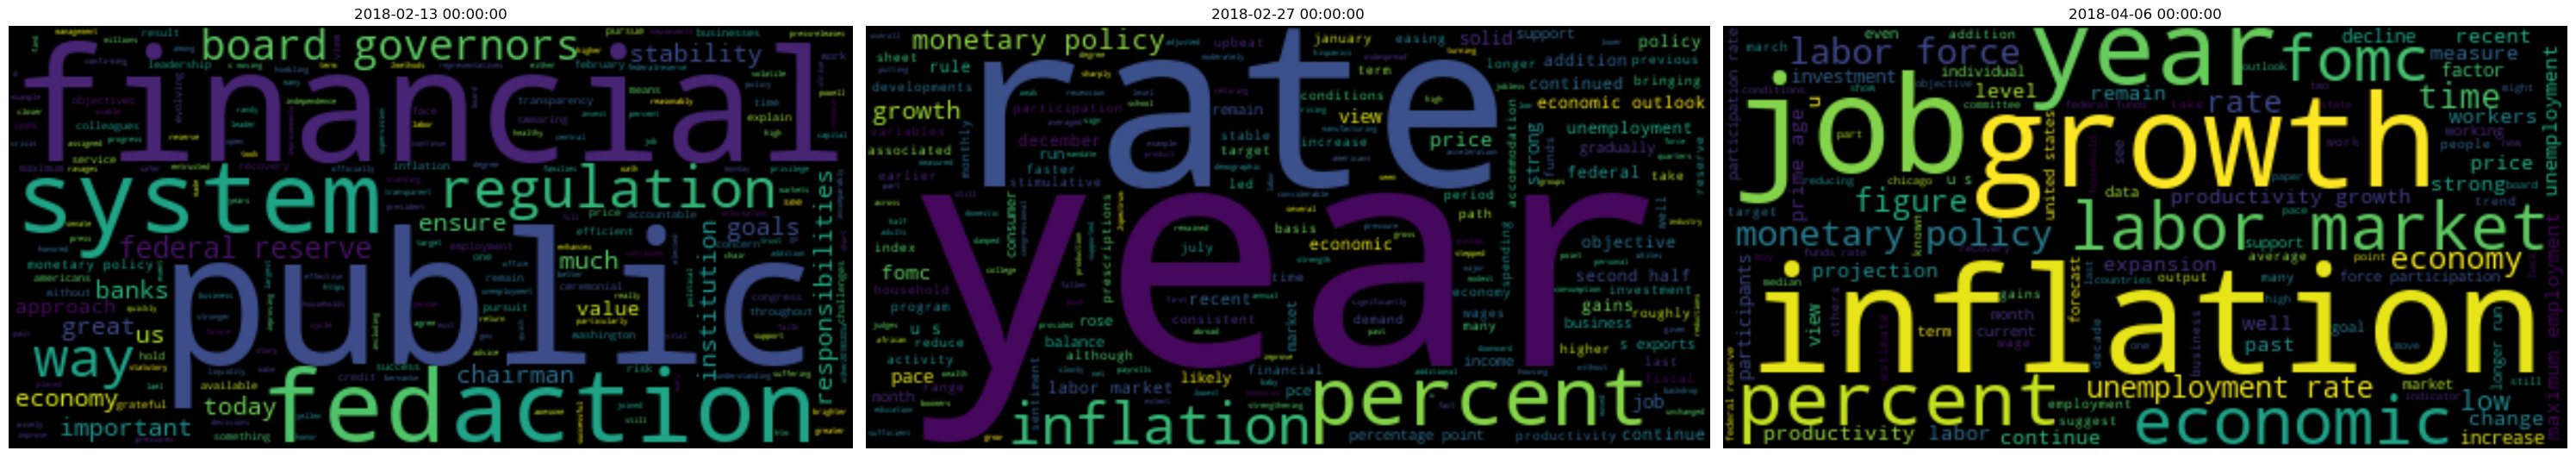

In [6]:
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(30, 20))

for (index, row), ax in zip(df.iterrows(), axs.ravel()):
    wc = WordCloud().generate(row['processed'])  
    ax.imshow(wc, interpolation='bilinear')
    ax.set_title(row['date'])  
    ax.axis('off')

plt.tight_layout()
plt.show()

In [7]:
export = pd.DataFrame()
export['date'] = df['date'].copy()
export['text'] = df['processed'].copy()
#export.to_csv('482 Cleaned Data.csv', sep=',', index=False)